<a href="https://colab.research.google.com/github/QuinnWass/CPSC-4310-01/blob/master/TW6/tw6_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TW5

## Linear regression

Students' names:

- Quinn Wass


- Brigid Kelly

- Pruevmaa Damdinsuren  

- Jonathan Pangelinan


### Set up 

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# to make this notebook's output stable across runs
np.random.seed(42)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Part 0

- Read and run each cell of the given examples: (1) synthetic dataset (2) crime dataset

- Understand the results

## Regression modeling

## Model evaluation metrics for regression

Evaluation metrics for classification problems, such as **accuracy**, are not useful for regression problems. Instead, we need evaluation metrics designed for comparing continuous values.

Let's create some example numeric predictions, and calculate **three common evaluation metrics** for regression problems:

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$


**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$


**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$


Comparing these metrics:

- **MAE** is the easiest to understand, because it's the average error.
- **MSE** is more popular than MAE, because MSE "punishes" larger errors.
- **RMSE** is even more popular than MSE, because RMSE is interpretable in the "y" units.

## The R2 ("r-squared") Regression Score

- Measures how well a prediction model for regression fits the given data.

- The score is between 0 and 1:

     - A value of 0 corresponds to a constant model that predicts the mean value of all training target values.

     - A value of 1 corresponds to perfect prediction

- Also known as "coefficient of determination"

### Preparing X and Y using pandas
- We already did this process above
- scikit-learn expects X (feature matrix) and Y (response vector) to be NumPy arrays.
- However, pandas is built on top of NumPy.
- Thus, X can be a pandas DataFrame and y can be a pandas Series!

### Dataset 1: Synthetic random data points

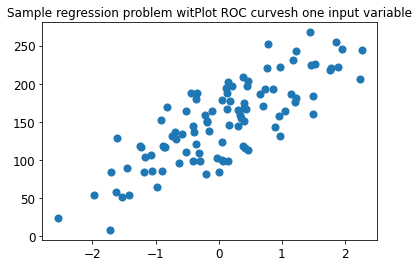

In [15]:
from sklearn.datasets import make_classification, make_blobs
from matplotlib.colors import ListedColormap

# synthetic dataset for simple regression
from sklearn.datasets import make_regression

plt.figure()
plt.title('Sample regression problem witPlot ROC curvesh one input variable')
X_R1, y_R1 = make_regression(n_samples = 100, n_features=1,
                            n_informative=1, bias = 150.0,
                            noise = 30, random_state=0)
plt.scatter(X_R1, y_R1, marker= 'o', s=50)
plt.show()

### Dataset 2: crime dataset

In [13]:
def load_crime_dataset():
    # Communities and Crime dataset for regression
    # https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime+Unnormalized

    # na_values='?'
    #crime = pd.read_csv('./data/CommViolPredUnnormalizedData.csv', na_values='?')

    crime_url = 'https://raw.githubusercontent.com/BAKelly12/CPSC4310-Random/master/TW6/CommViolPredUnnormalizedData.csv'
    crime = pd.read_csv(crime_url, na_values = '?')
    
    # remove features with poor coverage or lower relevance, and keep ViolentCrimesPerPop target column
    columns_to_keep = [5, 6] + list(range(11,26)) + list(range(32, 103)) + [145]  
    
    crime = crime.iloc[:, columns_to_keep]
    crime = crime.dropna()
    
    X_crime = crime.iloc[:, 0:88]
    y_crime = crime['ViolentCrimesPerPop']

    return (X_crime, y_crime)

# Communities and Crime dataset
(X_crime, y_crime) = load_crime_dataset()

print(X_crime.head())
print(y_crime.head())

   population  householdsize  ...  PctSameCity85  PctSameState85
0       11980           3.10  ...          78.09           89.14
1       23123           2.82  ...          90.22           96.12
2       29344           2.43  ...          61.26           82.85
3       16656           2.40  ...          90.17           96.24
5      140494           2.45  ...          70.61           85.66

[5 rows x 88 columns]
0     41.02
1    127.56
2    218.59
3    306.64
5    442.95
Name: ViolentCrimesPerPop, dtype: float64


### Dataset 3: Breast cancer dataset

In [12]:
from sklearn.datasets import load_breast_cancer

# Breast cancer dataset for classification
cancer = load_breast_cancer()
(X_cancer, y_cancer) = load_breast_cancer(return_X_y = True)

print(cancer.feature_names)
print(y_cancer)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0
 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0
 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0

## Linear models for regression

### 1. Linear regression on synthetic dataset

In [0]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X_R1, y_R1, random_state=0)

linreg = LinearRegression().fit(X_train, y_train)

#### Linear regression performance metrics

linear model coeff (w): [45.70870465]
linear model intercept (b): 148.446
R-squared score (training): 0.679
R-squared score (test): 0.492
RMSE: 33.203
(100, 1)
(100,)


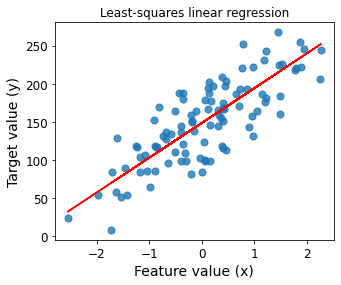

In [17]:
from sklearn import metrics

print('linear model coeff (w): {}'.format(linreg.coef_))

print('linear model intercept (b): {:.3f}'.format(linreg.intercept_))

print('R-squared score (training): {:.3f}'.format(linreg.score(X_train, y_train)))

print('R-squared score (test): {:.3f}'.format(linreg.score(X_test, y_test)))


# make predictions on the testing set
y_pred = linreg.predict(X_test)
print('RMSE: {:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

print(X_R1.shape)
print(y_R1.shape)
plt.figure(figsize=(5,4))
plt.scatter(X_R1, y_R1, marker= 'o', s=50, alpha=0.8)
plt.plot(X_R1, linreg.coef_ * X_R1 + linreg.intercept_, 'r-')
plt.title('Least-squares linear regression')
plt.xlabel('Feature value (x)')
plt.ylabel('Target value (y)')
plt.show()

In [0]:
X_b = np.c_[np.ones((100, 1)), X_R1]  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y_R1)
theta_best

array([147.55745452,  43.08728116])

### 2. Linear regression on crime dataset (without regularization)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_crime, y_crime, random_state=0)
linreg = LinearRegression().fit(X_train, y_train)

print('Crime dataset')
print('linear model intercept: {}'
     .format(linreg.intercept_))
print('linear model coeff:\n{}'
     .format(linreg.coef_))
print('R-squared score (training): {:.3f}'
     .format(linreg.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linreg.score(X_test, y_test)))



# make predictions on the testing set
y_pred = linreg.predict(X_test)
print('RMSE: {:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

Crime dataset
linear model intercept: -1728.1306725979102
linear model coeff:
[ 1.61892346e-03 -9.43009110e+01  1.36067510e+01 -3.13380670e+01
 -8.15482726e-02 -1.69455128e+01 -2.42730375e-03  1.53013232e+00
 -1.39193248e-02 -7.72112833e+00  2.28112354e+01 -5.65708295e+00
  9.34751364e+00  2.06969566e-01 -7.43413626e+00  9.65856476e-03
  4.38030290e-03  4.79754625e-03 -4.46469212e+00 -1.60907140e+01
  8.82778012e+00 -5.06734503e-01 -1.42198055e+00  8.17551991e+00
 -3.87048268e+00 -3.54209213e+00  4.48758304e+00  9.30645715e+00
  1.73644996e+02  1.18220766e+01  1.51120836e+02 -3.29613007e+02
 -1.35343395e+02  6.95380108e-01 -2.38369008e+01  2.77038981e+00
  3.82248925e-01  4.38813358e+00 -1.06410851e+01 -4.92294176e-03
  4.14031827e+01 -1.16206866e-03  1.18568968e+00  1.75418465e+00
 -3.68283678e+00  1.59679443e+00 -8.42180230e+00 -3.79703897e+01
  4.74076990e+01 -2.50768374e+01 -2.88246410e-01 -3.65633234e+01
  1.89516080e+01 -4.53336736e+01  6.82698598e+02  1.04478671e+02
 -3.28575414

### Ridge regression (regularized regression)

In [0]:
from sklearn.linear_model import Ridge
X_train, X_test, y_train, y_test = train_test_split(X_crime, y_crime, random_state=0)

linridge = Ridge(alpha=20.0).fit(X_train, y_train)

print('Crime dataset')
print('ridge regression linear model intercept: {}'
     .format(linridge.intercept_))
print('ridge regression linear model coeff:\n{}'
     .format(linridge.coef_))
print('R-squared score (training): {:.3f}'
     .format(linridge.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linridge.score(X_test, y_test)))
print('Number of non-zero features: {}'
     .format(np.sum(linridge.coef_ != 0)))

Crime dataset
ridge regression linear model intercept: -3352.423035846137
ridge regression linear model coeff:
[ 1.95091438e-03  2.19322667e+01  9.56286607e+00 -3.59178973e+01
  6.36465325e+00 -1.96885471e+01 -2.80715856e-03  1.66254486e+00
 -6.61426604e-03 -6.95450680e+00  1.71944731e+01 -5.62819154e+00
  8.83525114e+00  6.79085746e-01 -7.33614221e+00  6.70389803e-03
  9.78505502e-04  5.01202169e-03 -4.89870524e+00 -1.79270062e+01
  9.17572382e+00 -1.24454193e+00  1.21845360e+00  1.03233089e+01
 -3.78037278e+00 -3.73428973e+00  4.74595305e+00  8.42696855e+00
  3.09250005e+01  1.18644167e+01 -2.05183675e+00 -3.82210450e+01
  1.85081589e+01  1.52510829e+00 -2.20086608e+01  2.46283912e+00
  3.29328703e-01  4.02228467e+00 -1.12903533e+01 -4.69567413e-03
  4.27046505e+01 -1.22507167e-03  1.40795790e+00  9.35041855e-01
 -3.00464253e+00  1.12390514e+00 -1.82487653e+01 -1.54653407e+01
  2.41917002e+01 -1.32497562e+01 -4.20113118e-01 -3.59710660e+01
  1.29786751e+01 -2.80765995e+01  4.38513476

#### Ridge regression with feature normalization

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

from sklearn.linear_model import Ridge
X_train, X_test, y_train, y_test = train_test_split(X_crime, y_crime,
                                                   random_state = 0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linridge = Ridge(alpha=20.0).fit(X_train_scaled, y_train)

print('Crime dataset')
print('ridge regression linear model intercept: {}'
     .format(linridge.intercept_))
print('ridge regression linear model coeff:\n{}'
     .format(linridge.coef_))
print('R-squared score (training): {:.3f}'
     .format(linridge.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linridge.score(X_test_scaled, y_test)))
print('Number of non-zero features: {}'
     .format(np.sum(linridge.coef_ != 0)))

Crime dataset
ridge regression linear model intercept: 933.3906385044153
ridge regression linear model coeff:
[  88.68827454   16.48947987  -50.30285445  -82.90507574  -65.89507244
   -2.27674244   87.74108514  150.94862182   18.8802613   -31.05554992
  -43.13536109 -189.44266328   -4.52658099  107.97866804  -76.53358414
    2.86032762   34.95230077   90.13523036   52.46428263  -62.10898424
  115.01780357    2.66942023    6.94331369   -5.66646499 -101.55269144
  -36.9087526    -8.7053343    29.11999068  171.25963057   99.36919476
   75.06611841  123.63522539   95.24316483 -330.61044265 -442.30179004
 -284.49744001 -258.37150609   17.66431072 -101.70717151  110.64762887
  523.13611718   24.8208959     4.86533322  -30.46775619   -3.51753937
   50.57947231   10.84840601   18.27680946   44.11189865   58.33588176
   67.08698975  -57.93524659  116.1446052    53.81163718   49.01607711
   -7.62262031   55.14288543  -52.08878272  123.39291017   77.12562171
   45.49795317  184.91229771  -91.3572

#### Ridge regression with regularization parameter: alpha

In [0]:
print('Ridge regression: effect of alpha regularization parameter\n')
for this_alpha in [0, 1, 10, 20, 50, 100, 1000]:
    linridge = Ridge(alpha = this_alpha).fit(X_train_scaled, y_train)
    r2_train = linridge.score(X_train_scaled, y_train)
    r2_test = linridge.score(X_test_scaled, y_test)
    num_coeff_bigger = np.sum(abs(linridge.coef_) > 1.0)
    print('Alpha = {:.2f}\nnum abs(coeff) > 1.0: {}, \
r-squared training: {:.2f}, r-squared test: {:.2f}\n'
         .format(this_alpha, num_coeff_bigger, r2_train, r2_test))

Ridge regression: effect of alpha regularization parameter

Alpha = 0.00
num abs(coeff) > 1.0: 88, r-squared training: 0.67, r-squared test: 0.50

Alpha = 1.00
num abs(coeff) > 1.0: 87, r-squared training: 0.66, r-squared test: 0.56

Alpha = 10.00
num abs(coeff) > 1.0: 87, r-squared training: 0.63, r-squared test: 0.59

Alpha = 20.00
num abs(coeff) > 1.0: 88, r-squared training: 0.61, r-squared test: 0.60

Alpha = 50.00
num abs(coeff) > 1.0: 86, r-squared training: 0.58, r-squared test: 0.58

Alpha = 100.00
num abs(coeff) > 1.0: 87, r-squared training: 0.55, r-squared test: 0.55

Alpha = 1000.00
num abs(coeff) > 1.0: 84, r-squared training: 0.31, r-squared test: 0.30



### Lasso regression

In [0]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X_crime, y_crime,
                                                   random_state = 0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linlasso = Lasso(alpha=2.0, max_iter = 10000).fit(X_train_scaled, y_train)

print('Crime dataset')
print('lasso regression linear model intercept: {}'
     .format(linlasso.intercept_))
print('lasso regression linear model coeff:\n{}'
     .format(linlasso.coef_))
print('Non-zero features: {}'
     .format(np.sum(linlasso.coef_ != 0)))
print('R-squared score (training): {:.3f}'
     .format(linlasso.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}\n'
     .format(linlasso.score(X_test_scaled, y_test)))
print('Features with non-zero weight (sorted by absolute magnitude):')

for e in sorted (list(zip(list(X_crime), linlasso.coef_)),
                key = lambda e: -abs(e[1])):
    if e[1] != 0:
        print('\t{}, {:.3f}'.format(e[0], e[1]))

Crime dataset
lasso regression linear model intercept: 1186.612061998579
lasso regression linear model coeff:
[    0.             0.            -0.          -168.18346054
    -0.            -0.             0.           119.6938194
     0.            -0.             0.          -169.67564456
    -0.             0.            -0.             0.
     0.             0.            -0.            -0.
     0.            -0.             0.             0.
   -57.52991966    -0.            -0.             0.
   259.32889226    -0.             0.             0.
     0.            -0.         -1188.7396867     -0.
    -0.            -0.          -231.42347299     0.
  1488.36512229     0.            -0.            -0.
    -0.             0.             0.             0.
     0.             0.            -0.             0.
    20.14419415     0.             0.             0.
     0.             0.           339.04468804     0.
     0.           459.53799903    -0.             0.
   122.69221826    

#### Lasso regression with regularization parameter: alpha

In [0]:
print('Lasso regression: effect of alpha regularization\n\
parameter on number of features kept in final model\n')

for alpha in [0.5, 1, 2, 3, 5, 10, 20, 50]:
    linlasso = Lasso(alpha, max_iter = 10000).fit(X_train_scaled, y_train)
    r2_train = linlasso.score(X_train_scaled, y_train)
    r2_test = linlasso.score(X_test_scaled, y_test)
    
    print('Alpha = {:.2f}\nFeatures kept: {}, r-squared training: {:.2f}, \
r-squared test: {:.2f}\n'
         .format(alpha, np.sum(linlasso.coef_ != 0), r2_train, r2_test))

Lasso regression: effect of alpha regularization
parameter on number of features kept in final model

Alpha = 0.50
Features kept: 35, r-squared training: 0.65, r-squared test: 0.58

Alpha = 1.00
Features kept: 25, r-squared training: 0.64, r-squared test: 0.60

Alpha = 2.00
Features kept: 20, r-squared training: 0.63, r-squared test: 0.62

Alpha = 3.00
Features kept: 17, r-squared training: 0.62, r-squared test: 0.63

Alpha = 5.00
Features kept: 12, r-squared training: 0.60, r-squared test: 0.61

Alpha = 10.00
Features kept: 6, r-squared training: 0.57, r-squared test: 0.58

Alpha = 20.00
Features kept: 2, r-squared training: 0.51, r-squared test: 0.50

Alpha = 50.00
Features kept: 1, r-squared training: 0.31, r-squared test: 0.30



## Part 1


Apply the following regression model on breast cancer dataset

(1) Linear regression without regularization

(2) Ridge regression 

(3) Ridge regression with feature normalization

(4) Ridge regression with regularization parameter: alpha

(5) Lasso regression

(6) Lasso regression with regularization parameter: alpha

In [35]:
from sklearn.datasets import load_breast_cancer

# Breast cancer dataset for classification
cancer = load_breast_cancer()
(X_cancer, y_cancer) = load_breast_cancer(return_X_y = True)

print(cancer.feature_names)
print(y_cancer)

from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, random_state=0)

linreg = LinearRegression().fit(X_train, y_train)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0
 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0
 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0

linear model coeff (w): [ 1.95664033e-01 -1.24998359e-02 -1.83925145e-02 -3.08554299e-04
 -6.58769659e-01  4.67316114e+00 -1.41047944e+00 -1.79519061e+00
 -1.02466251e+00 -8.16682870e-01 -6.95506836e-01 -2.65194673e-02
  6.52894932e-02  3.22253562e-04 -1.16323309e+01 -4.43943865e-02
  3.04134165e+00 -8.31729413e+00 -2.44644000e+00  1.96844051e+01
 -1.78964757e-01 -2.00410588e-04 -4.02896117e-03  1.17548563e-03
 -4.04988322e-01 -1.15267671e-01 -4.11583121e-01 -9.11239745e-01
 -1.12925131e-01 -5.02459596e+00]
linear model intercept (b): 3.264
R-squared score (training): 0.782
R-squared score (test): 0.729
RMSE: 0.251
(569, 30)
(569,)


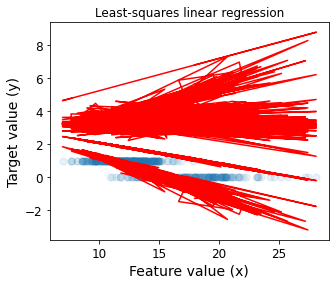

In [54]:
from sklearn import metrics

print('linear model coeff (w): {}'.format(linreg.coef_))

print('linear model intercept (b): {:.3f}'.format(linreg.intercept_))

print('R-squared score (training): {:.3f}'.format(linreg.score(X_train, y_train)))

print('R-squared score (test): {:.3f}'.format(linreg.score(X_test, y_test)))


# make predictions on the testing set
y_pred = linreg.predict(X_test)
print('RMSE: {:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

print(X_cancer.shape)
print(y_cancer.shape)
plt.figure(figsize=(5,4))
plt.scatter(X_cancer[:,0], y_cancer, marker= 'o', s=50, alpha=0.1)
plt.plot(X_cancer[:,0], linreg.coef_ * X_cancer + linreg.intercept_, 'r-')
plt.title('Least-squares linear regression')
plt.xlabel('Feature value (x)')
plt.ylabel('Target value (y)')
plt.show()

Crime dataset
ridge regression linear model intercept: 2.8876581523658817
ridge regression linear model coeff:
[ 8.95459514e-02  4.96576604e-03 -6.53071472e-03 -9.38715208e-06
 -1.70744323e-02 -2.48627421e-02 -4.93503540e-02 -2.77020642e-02
 -3.06915402e-02 -4.70309146e-03 -4.64609813e-02 -1.10244435e-02
 -1.66584359e-02 -3.44749865e-04 -2.54152959e-03  2.62285611e-04
 -1.16547194e-03 -2.54907417e-03 -5.31339660e-03 -7.79367812e-05
 -1.60523115e-01 -1.55701325e-02 -6.49252297e-03  1.01356127e-03
 -3.15652552e-02 -8.47221763e-02 -1.40803334e-01 -5.21846681e-02
 -6.76483639e-02 -1.53442711e-02]
R-squared score (training): 0.718
R-squared score (test): 0.701
Number of non-zero features: 30


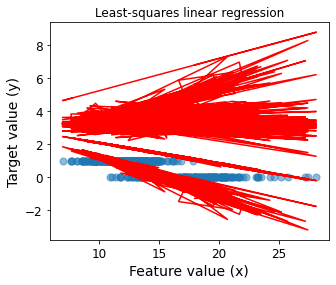

In [53]:
from sklearn.datasets import load_breast_cancer

# Breast cancer dataset for classification
cancer = load_breast_cancer()
(X_cancer, y_cancer) = load_breast_cancer(return_X_y = True)
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
linridge = Ridge(alpha=20.0).fit(X_train, y_train)

print('Crime dataset')
print('ridge regression linear model intercept: {}'
     .format(linridge.intercept_))
print('ridge regression linear model coeff:\n{}'
     .format(linridge.coef_))
print('R-squared score (training): {:.3f}'
     .format(linridge.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linridge.score(X_test, y_test)))
print('Number of non-zero features: {}'
     .format(np.sum(linridge.coef_ != 0)))
plt.figure(figsize=(5,4))
plt.scatter(X_cancer[:,0], y_cancer, marker= 'o', s=50, alpha=0.5)
plt.plot(X_cancer[:,0], linreg.coef_ * X_cancer + linreg.intercept_, 'r-')
plt.title('Least-squares linear regression')
plt.xlabel('Feature value (x)')
plt.ylabel('Target value (y)')
plt.show()

In [47]:
print('Ridge regression: effect of alpha regularization parameter\n')
for this_alpha in [0, 1, 10, 20, 50, 100, 1000]:
    linridge = Ridge(alpha = this_alpha).fit(X_train_scaled, y_train)
    r2_train = linridge.score(X_train_scaled, y_train)
    r2_test = linridge.score(X_test_scaled, y_test)
    num_coeff_bigger = np.sum(abs(linridge.coef_) > 1.0)
    print('Alpha = {:.2f}\nnum abs(coeff) > 1.0: {}, \
r-squared training: {:.2f}, r-squared test: {:.2f}\n'
         .format(this_alpha, num_coeff_bigger, r2_train, r2_test))

Ridge regression: effect of alpha regularization parameter

Alpha = 0.00
num abs(coeff) > 1.0: 8, r-squared training: 0.78, r-squared test: 0.73

Alpha = 1.00
num abs(coeff) > 1.0: 0, r-squared training: 0.75, r-squared test: 0.73

Alpha = 10.00
num abs(coeff) > 1.0: 0, r-squared training: 0.72, r-squared test: 0.71

Alpha = 20.00
num abs(coeff) > 1.0: 0, r-squared training: 0.70, r-squared test: 0.70

Alpha = 50.00
num abs(coeff) > 1.0: 0, r-squared training: 0.65, r-squared test: 0.65

Alpha = 100.00
num abs(coeff) > 1.0: 0, r-squared training: 0.57, r-squared test: 0.58

Alpha = 1000.00
num abs(coeff) > 1.0: 0, r-squared training: 0.16, r-squared test: 0.16



Crime dataset
lasso regression linear model intercept: 0.6267605633802817
lasso regression linear model coeff:
[-0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0.  0. -0. -0.  0. -0. -0. -0.
  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
Non-zero features: 0
R-squared score (training): 0.000
R-squared score (test): -0.000

Features with non-zero weight (sorted by absolute magnitude):


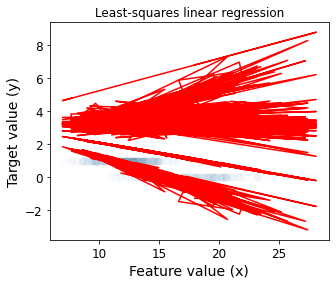

In [56]:
from sklearn.datasets import load_breast_cancer

# Breast cancer dataset for classification
cancer = load_breast_cancer()
(X_cancer, y_cancer) = load_breast_cancer(return_X_y = True)

from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from sklearn.datasets import load_breast_cancer

# Breast cancer dataset for classification
cancer = load_breast_cancer()
(X_cancer, y_cancer) = load_breast_cancer(return_X_y = True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linlasso = Lasso(alpha=2.0, max_iter = 10000).fit(X_train_scaled, y_train)

print('Crime dataset')
print('lasso regression linear model intercept: {}'
     .format(linlasso.intercept_))
print('lasso regression linear model coeff:\n{}'
     .format(linlasso.coef_))
print('Non-zero features: {}'
     .format(np.sum(linlasso.coef_ != 0)))
print('R-squared score (training): {:.3f}'
     .format(linlasso.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}\n'
     .format(linlasso.score(X_test_scaled, y_test)))
print('Features with non-zero weight (sorted by absolute magnitude):')

for e in sorted (list(zip(list(X_crime), linlasso.coef_)),
                key = lambda e: -abs(e[1])):
    if e[1] != 0:
        print('\t{}, {:.3f}'.format(e[0], e[1]))
plt.figure(figsize=(5,4))
plt.scatter(X_cancer[:,0], y_cancer, marker= 'o', s=50, alpha=0.01)
plt.plot(X_cancer[:,0], linreg.coef_ * X_cancer + linreg.intercept_, 'r-')
plt.title('Least-squares linear regression')
plt.xlabel('Feature value (x)')
plt.ylabel('Target value (y)')
plt.show()

## Part 2

- Read and run each cell of the given examples: (1) synthetic dataset (2) crime dataset
- Understand the results

### K-NN Regression

In [0]:
from sklearn.neighbors import KNeighborsRegressor

X_train, X_test, y_train, y_test = train_test_split(X_R1, y_R1, random_state = 0)

knnreg = KNeighborsRegressor(n_neighbors = 5).fit(X_train, y_train)

print(knnreg.predict(X_test))
print('R-squared test score: {:.3f}'
     .format(knnreg.score(X_test, y_test)))

In [0]:
fig, subaxes = plt.subplots(1, 2, figsize=(8,4))
X_predict_input = np.linspace(-3, 3, 50).reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X_R1[0::5], y_R1[0::5], random_state = 0)

for thisaxis, K in zip(subaxes, [1, 3]):
    knnreg = KNeighborsRegressor(n_neighbors = K).fit(X_train, y_train)
    y_predict_output = knnreg.predict(X_predict_input)
    thisaxis.set_xlim([-2.5, 0.75])
    thisaxis.plot(X_predict_input, y_predict_output, '^', markersize = 10,
                 label='Predicted', alpha=0.8)
    thisaxis.plot(X_train, y_train, 'o', label='True Value', alpha=0.8)
    thisaxis.set_xlabel('Input feature')
    thisaxis.set_ylabel('Target value')
    thisaxis.set_title('KNN regression (K={})'.format(K))
    thisaxis.legend()
plt.tight_layout()

### Regression model complexity as a function of K

In [0]:
# plot k-NN regression on sample dataset for different values of K
fig, subaxes = plt.subplots(5, 1, figsize=(5,20))
X_predict_input = np.linspace(-3, 3, 500).reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X_R1, y_R1,
                                                   random_state = 0)

for thisaxis, K in zip(subaxes, [1, 3, 7, 15, 55]):
    knnreg = KNeighborsRegressor(n_neighbors = K).fit(X_train, y_train)
    y_predict_output = knnreg.predict(X_predict_input)
    train_score = knnreg.score(X_train, y_train)
    test_score = knnreg.score(X_test, y_test)
    thisaxis.plot(X_predict_input, y_predict_output)
    thisaxis.plot(X_train, y_train, 'o', alpha=0.9, label='Train')
    thisaxis.plot(X_test, y_test, '^', alpha=0.9, label='Test')
    thisaxis.set_xlabel('Input feature')
    thisaxis.set_ylabel('Target value')
    thisaxis.set_title('KNN Regression (K={})\n\
Train $R^2 = {:.3f}$,  Test $R^2 = {:.3f}$'
                      .format(K, train_score, test_score))
    thisaxis.legend()
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)